#### Virus genome 
5. Using `STAR` to build index and map COVID19 genome to unaligned reads to the human genome.
    According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)), I'm using [this genome annotation](https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide). 
        - input: fastq
            output2 of step 2. 
        - output: bam 


6. Using `exomePeak` with custom option that make it work for calling virus peaks. 
        - input1: gtf
        - input2: bam
        - output: bed12

7. Albertas is using m6A+ m6A- internal controls from [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94). I'm using `bowtie2` to align reads in the `output2` from step 2. In a scatter plot, qPCR Ct for each patients is compered with number of virus m6A peaks.


8. Merge and intersect peaks found in all samples into a single `bed6` file and extract peak sequences. 
        - inputs: bed12
            outputs of step 6
        - output1: bed
        - output2: fasta

9. Count virus peaks as features using `bamToBed` plus `intersectBed` to count reads that aligned to each peaks. 
        - input1: bam 
            output of step 5.
        - input2: bed
            output1 of step 8. 
        - output: count-matrix 

        
10. Motif analysis using `regex` by extracting the sequence of each peaks and quary patterns
        - input: fasta
            output2 of step 8. 
        - output: motif-dataframe


12. Implement R code from [here](https://github.com/lzcyzm/exomePeak/blob/master/R/ctest.R) to run `ctest` which evaluate m6A vs. input foldchange, pvalue and fdr for every peaks in all 22 samples. 


11. Also, there are WGS `fasta` results for several samples. For mutation analysis, I'm applying fuzzy string matching which calculate **Levenshtein Distance** between each peak sequence within the sample sequence.

In [2]:
import re
import os 
import sys 
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from scipy import stats 
from matplotlib.patches import Rectangle
import sklearn.preprocessing as pp
import rpy2.robjects as ob

print (sys.version)

3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0]


In [3]:
Samples = [
    "S0008","S0009","S0014","S0017","S0025",
    "S0026","S0030","S0042","S0057","S0085",
    "COV00075","COV00079","COV00084","COV00087","COV00093","COV00106",
    "COV00397","COV00413","COV00417","COV00419","COV00422","COV00432"    
]

In [5]:
renameSamples = [S.replace('S', 'COV0') for S in Samples]

In [6]:
motif_df = pd.read_csv('Results/motif_analysis.txt', sep='\t')
motif_df

,Unnamed: 0,loci,DRACH,RGAC,AAGAA,Sequence
0,0,S_peak,12,3,0,"GGACT,GAACC,AGACT,TGACC,AAACA,AAACT,TAACT,AAAC..."
1,2,S_peak_3,3,1,0,"GAACT,TGACA,TGACC,AGAC"
2,3,S_peak_4,23,7,1,"GAACT,TGACA,GGACT,GGACC,TAACC,TAACA,AGACC,AAAC..."
3,4,S_peak_5,2,0,0,"TAACA,AAACC"
4,5,S_peak_6,4,1,0,"GAACT,GGACC,AAACA,TAACA,GGAC"
...,...,...,...,...,...,...
161,163,N_peak_43,35,12,5,"GGACC,GGACC,TAACC,AAACA,AGACC,GGACA,TAACA,TGAC..."
162,164,N_peak_44,7,4,0,"GGACC,TAACC,AAACA,AGACC,GGACA,TAACA,TGACC,GGAC..."
163,165,N_peak_45,1,0,0,GAACA
164,166,N_peak_46,5,1,0,"AGACA,GAACT,AAACA,TGACC,TGACA,AGAC"


Let's filter some peaks with `DRACH` and `RGAC` motifs for below analysis:

In [9]:
peaks_with_motifs = motif_df[
    (motif_df.DRACH > 1) # & (motif_df.DRACH < 8) 
    &
    (motif_df.RGAC > 0)
    &
    (motif_df.AAGAA > 0)
].loci.tolist()
len(peaks_with_motifs)

48

We can draw borders around peaks which was significant in ctest. So, we have foldchange, pvalue, fdr for every peaks in every sample. 
There is WGS results for 
Also, we can zoom into peaks with expected motifs, peaks which mutated and etc. 

In [43]:
def read_counts(samples):
    '''
    Read raw counnt for IN and RIP into a pandas DataFrame    
    '''
    all_samples = np.concatenate([[N+'_IN',N+'_RIP'] for N in samples]).tolist()
    # Read count files as dataframe
    df_list = [
        pd.read_csv('virus_count/' + file, header=None, sep='\t', index_col=0) 
        for file in [N+'.fc' for N in all_samples]
    ]
    # concatenate them together 
    data = pd.concat(df_list, axis=1)
    data.columns = all_samples
    return data


def peak_names(samples):
    '''
    Extract peak names    
    '''
    peak_names = read_counts(samples).index.tolist()
    return peak_names


def add_border(plot,sig):
    '''
    For a given heatmap plot [plot], this function draw rectangles 
    around an array defined as list in the input indices.  
    '''
    i,j = sig
    plot.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='red', lw=5))

    
# https://towardsdatascience.com/how-to-create-a-plotly-visualization-and-embed-it-on-websites-517c1a78568b
def draw_heatmap(data, borders=None, save=False, name_it='', vmin=None,vmax=None):
    '''
    Draw/save heatmap plot with option to draw rectangle around given cells 
    '''
    heat_map = sns.heatmap(data,linewidth=2, vmin=vmin,vmax=vmax)
    # add borders 
    if borders: 
        for sig in borders: add_border (heat_map,sig)
    bottom, top = heat_map.get_ylim()
    heat_map.set_ylim(bottom + 0.5, top - 0.5)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
    if save:
        plt.savefig(name_it + '.png')
        plt.savefig(name_it + '.pdf')
    else:
        plt.show()

Peak_names = peak_names(Samples)
Counts = read_counts(Samples)

Counts.to_csv('Results/raw_counts.txt', sep='\t')

`ctest` results for every peaks in every samples are ready to go! 

In [20]:
pd.DataFrame([np.array(R[0]) for R in RESULTS], index=Samples,columns=Peak_names)
= pd.DataFrame([np.array(R[1]) for R in RESULTS], index=Samples,columns=Peak_names)
log_fc = pd.DataFrame([np.array(R[2]) for R in RESULTS], index=Samples,columns=Peak_names)

In [48]:
log_p  = pd.read_csv('Results/ctest_log_p.txt', sep='\t')
log_fdr= pd.read_csv('Results/ctest_log_fdr.txt', sep='\t')
log_fc = pd.read_csv('Results/ctest_log_fc.txt', sep='\t')

In [502]:

# for s, (name, df) in enumerate(zip(Samples,df_list)):
#     peak = df.index.drop_duplicates(keep='last')
#     borders = pvalues + [[n,s,] for n, p in enumerate(Peak_names) if p in peak]
# #     pvalues_df.loc[peak,name] = 

# # return pvalues
# pvalues_df

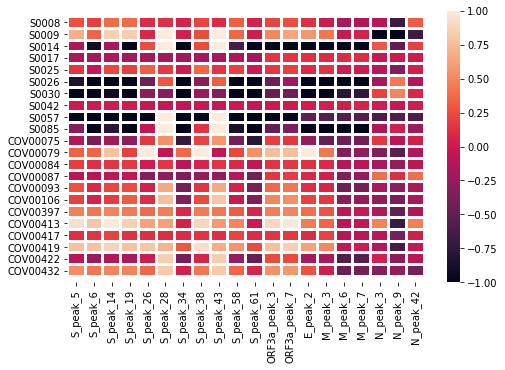

In [457]:
plt.figure(figsize=(8,5))
draw_heatmap(log_fc.loc[Samples,mutated_peaks], vmin=-1,vmax=1)

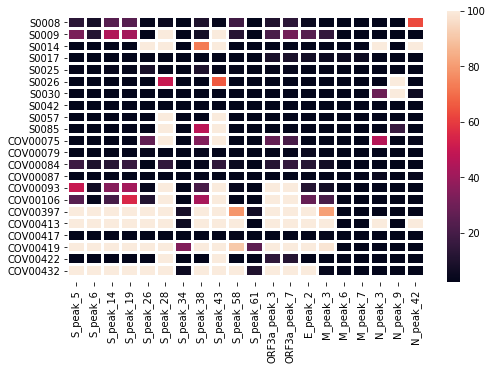

In [465]:
plt.figure(figsize=(8,5))
draw_heatmap(
    -1*log_p.loc[Samples,mutated_peaks], vmin = 2, vmax = 100
)

In [1]:
c = sns.clustermap(
    -1*log_p.loc[Samples,mutated_peaks],
    col_cluster=False, linewidth=2,vmax=25,
    method = 'complete',
    figsize=(8,5)
)

bottom, top = c.ax_heatmap.get_ylim()
c.ax_heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
# plt.savefig(name_it + '.png')
# plt.savefig(name_it + '.pdf')


NameError: name 'sns' is not defined

## 12. Mutation analysis 

https://www.datacamp.com/community/tutorials/fuzzy-string-python

Levenshtein Distance Equation
https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0

In [237]:
# peak sequences as dataframe
peak_seq_df = pd.DataFrame(
    list(peak_sequence.items()),
    columns = ['coordinate','sequence']
) 
peak_seq_df.index = [peak_seq_df.loc[p,'coordinate'].split('::')[0] for p in peak_seq_df.index]

In [238]:
# WGS sequencing of patient samples as datafram
files = glob.glob('virus_WGS/*.fasta')
sample_seq_df = pd.DataFrame(columns = ['sequence']) 
for f in files:
    sample = f.replace('virus_WGS/NM-n','').replace('.fasta','')
    sample_seq_df.loc[sample] = list(read_fasta(f).values())

In [243]:
# build empty numpy array 
mutation_mat = np.zeros((
    sample_seq_df.shape[0], 
    peak_seq_df.shape[0]  
))

# nested for loop to run string matching between peak and sample sequencing
for i, sample in enumerate(sample_seq_df['sequence'].to_list() ):
    for j,peak in enumerate(peak_seq_df['sequence'].to_list() ):
        mutation_mat[i,j] = fuzz.partial_ratio(sample, peak)
        
# column normalization of partial_ratio score
mutation_mat_norm = pp.minmax_scale(mutation_mat, axis=0)

mutation_df = pd.DataFrame(
    mutation_mat,
    index=sample_seq_df.index.to_list(), columns=peak_seq_df.index.to_list()
)

mutation_norm_df = pd.DataFrame(
    mutation_mat_norm,
    index=sample_seq_df.index.to_list(), columns=peak_seq_df.index.to_list()
)

mutation_df.to_csv('Results/mutation_mat_fuzzy_partial_ratio.txt', sep='\t')
mutation_norm_df.to_csv('Results/mutation_mat_norm.txt', sep='\t')

In [396]:
fresh = (100 - mutation_mat) - 30 
fresh_df = pd.DataFrame(
    fresh,
    index=sample_seq_df.index.to_list(), columns=peak_seq_df.index.to_list()
)

In [452]:
mutated_peaks = mutation_norm_df.sum(axis=0) > 0

In [472]:
# plt.figure(figsize=(8,5))
# draw_heatmap(mutation_norm_df.loc[:,mutated_peaks], )
# mutation_norm_df.loc[:,mutated_peaks]

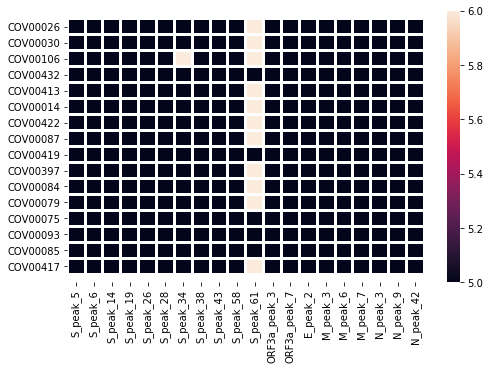

In [454]:
plt.figure(figsize=(8,5))
draw_heatmap(fresh_df.loc[:,mutated_peaks], vmin=5)#, vmax=7)

(not used scripts)

### Total number of reads:
1. Using `samtools` to convert `bam` files to `fastq` files 
2. Count total number of lines / by 4 as total number of reads 

virus

In [490]:
%%bash --err error
mkdir -p total
echo 'sample, reads' > total/virus.txt
for f in virus_bam/*bam;
	do 
    name=`basename $f`
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/virus.txt
done

human 

In [491]:
%%bash --err error
echo 'sample, reads' > total/human.txt
for f in */bam/*.bam; 
	do 
    name=`basename $f`
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/human.txt
done

ctrl m6A_neg

In [16]:
%%bash --err error
echo 'sample, reads' > total/m6A_neg.txt
for f in */int_ctrl/virus/m6A_neg/*bam; 
	do 
    name=`basename $f`
    name=${name/_S[0-9]*/}
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/m6A_neg.txt
done

ctrl m6A_pos

In [15]:
%%bash --err error
echo 'sample, reads' > total/m6A_pos.txt
for f in */int_ctrl/virus/m6A_pos/*bam; 
	do 
    name=`basename $f`
    name=${name/_S[0-9]*/}
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/m6A_pos.txt
done

In [266]:
aligned = ['human','virus','m6A_pos','m6A_neg']
total_df = pd.concat([pd.read_csv('total/'+a+'.txt', sep=',', index_col=0).sort_index() for a in aligned],axis=1)
total_df.columns = aligned

total_df.to_csv('total_reads.txt', sep='\t')

#### Read and normalize counts 
Log normalization of peak counts 

$$\log_2 \dfrac{
    \dfrac{\text{m6A counts in the peak}}{\text{m6A total counts}}
    }{
    \dfrac{\text{input counts in the peak}}{\text{input total counts}}
    }
    $$


In [ ]:
# def norm_counts(counts, samples, total_reads, norm='l1'):
#     all_samples = np.concatenate([[N+'_IN',N+'_RIP'] for N in samples]).tolist()    
#     peak_names = counts.index.tolist()
#     n_sam = len(all_samples)
#     # normalize
#     total = total_reads.loc[all_samples,].sum(axis=1)
#     total = np.array(total).T
#     data = np.array(counts[all_samples]) 
#     # log2 (RIP in peak / RIP total) / (IN in peak / IN total)
#     res = np.log2(
#         (
#             # RIP / RIP ctrl
#             data [:,np.array(range(1,n_sam,2))] 
#             /
#             total[np.array(range(1,n_sam,2))]
#         ) / (
#             # IN / IN ctrl
#             data [:,np.array(range(0,n_sam,2))] 
#             /
#             total[np.array(range(0,n_sam,2))]
#         )
#     )
#     # normalization by samples
#     if norm == None:
#         res = res
#     elif norm == 'min':
#         res = pp.minmax_scale(res, feature_range=(0, 1), axis=1)
#     elif norm == 'zscore':
#         res = stats.zscore(res, axis=0, ddof=1)
#     else:
#         res = pp.normalize(res, axis=1, norm=norm)
#     res_df = pd.DataFrame(data=res, columns=samples, index=peak_names)
#     return res_df


# Total = pd.read_csv('total_reads.txt', sep = '\t', index_col=0)  
# Norm_counts = norm_counts(Counts, Samples, Total, norm=None)
# Norm_counts.to_csv('norm_counts.txt', sep='\t')